In [1]:
#!pip install git+https://github.com/JoaquinAmatRodrigo/skforecast#master --upgrade

In [8]:
# Libraries
# ==============================================================================
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/ximo/Documents/GitHub/skforecast')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
import warnings

%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

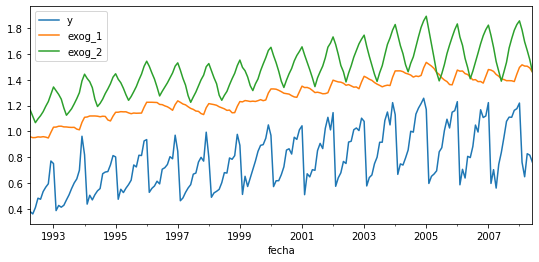

In [2]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',')

# data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax);

# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

# ForecasterAutoreg without exogenous variables

In [3]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor=make_pipeline(StandardScaler(), Ridge()),
                    lags=15
                )

forecaster.fit(y=data_train.y)
forecaster

<class 'skforecast.ForecasterAutoreg.ForecasterAutoreg'> 
Regressor: Ridge() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Window size: 15 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'> 
Training index frequancy: MS 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001} 

Test error (mse): 0.010454411313511013


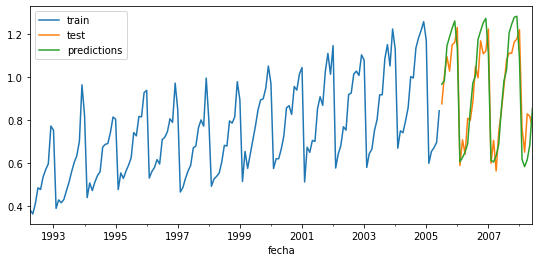

In [140]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test.y,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [146]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor=make_pipeline(StandardScaler(), Ridge()),
                lags=12
             )

# Regressor hiperparameters
param_grid ={'ridge__alpha': [0.01, 0.1, 1]}

# lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train.y,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        refit       = True,
                        initial_train_size    = int(len(data_train)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid.head(4)

Number of models compared: 9


loop lags_grid: 100%|█████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]

Refitting `forecaster` using the best found parameters and the whole data set: 
  lags: [ 1  2  3  4  5  6  7  8  9 10] 
  params: {'ridge__alpha': 0.01}



,lags,params,metric,ridge__alpha
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'ridge__alpha': 0.01},0.025726,0.01
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'ridge__alpha': 0.1},0.025732,0.10
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'ridge__alpha': 1},0.025815,1.00
6,"[1, 2, 3, 20]",{'ridge__alpha': 0.01},0.043819,0.01


In [149]:
# Predictors importance
# ==============================================================================
forecaster.get_coef()

,feature,coef
0,lag_1,0.128890
1,lag_2,-0.009212
2,lag_3,0.023736
3,lag_4,-0.020876
4,lag_5,-0.009362
5,lag_6,0.009474
6,lag_7,-0.027663
7,lag_8,0.013131
8,lag_9,0.011912
9,lag_10,0.053554


Number of observations used for training or as initial window: 86
Number of observations used for backtesting: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
[0.02897809]


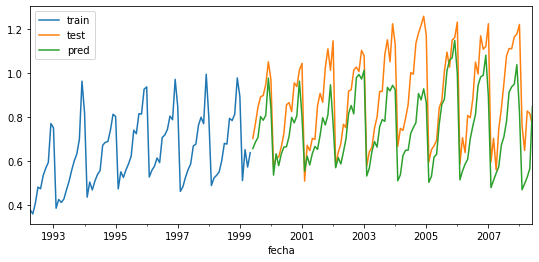

In [154]:
# Backtesting
# ==============================================================================
steps = 36
n_backtest = 36 * 3 + 1
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]


forecaster = ForecasterAutoreg(
                regressor = make_pipeline(StandardScaler(), Ridge()),
                lags = 15
             )

metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = len(data_train),
                                    steps      = steps,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                                )
print(metrica)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predictions')
ax.legend();

In [155]:
predicciones_backtest

,pred
1999-06-01,0.657671
1999-07-01,0.686794
1999-08-01,0.708450
1999-09-01,0.802705
1999-10-01,0.786050
...,...
2008-02-01,0.471187
2008-03-01,0.498920
2008-04-01,0.528226
2008-05-01,0.567324


In [156]:
forecaster.fit(y=data_train.y)
predictions_1 = forecaster.predict(steps=steps)
predictions_2 = forecaster.predict(steps=steps, last_window=data_test.y[:steps])
predictions_3 = forecaster.predict(steps=steps, last_window=data_test.y[steps:steps*2])
predictions_4 = forecaster.predict(steps=1, last_window=data_test.y[steps*2:steps*3])
np.allclose(predicciones_backtest['pred'], np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4]))

True

# ForecasterAutoreg with 1 exogenous variables

In [159]:
# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

In [164]:
forecaster = ForecasterAutoreg(
                regressor = make_pipeline(StandardScaler(), Ridge()),
                lags      = 8
              )
forecaster

<class 'skforecast.ForecasterAutoreg.ForecasterAutoreg'> 
Regressor: Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]) 
Lags: [1 2 3 4 5 6 7 8] 
Window size: 8 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequancy: None 
Regressor parameters: {'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'ridge__alpha': 1.0, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__normalize': 'deprecated', 'ridge__positive': False, 'ridge__random_state': None, 'ridge__solver': 'auto', 'ridge__tol': 0.001} 

Test error (mse): 0.023002872983181696


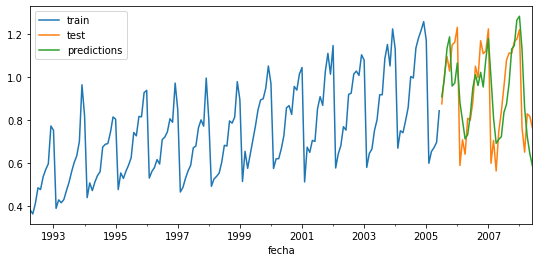

In [165]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = make_pipeline(StandardScaler(), Ridge()),
                lags      = 8
             )

forecaster.fit(y=data_train.y, exog=data_train.exog_1)

# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=data_test.exog_1)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error prediction
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test.y,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

In [170]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor= make_pipeline(StandardScaler(), RandomForestRegressor(random_state=123)),
                lags=12
             )

# Regressor hiperparameters
param_grid = {'randomforestregressor__n_estimators': [50, 100],
              'randomforestregressor__max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train.y,
                        exog        = data_train.exog_1,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        refit       = False,
                        initial_train_size    = int(len(data_train)*0.5),
                        return_best = False,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid.head(4)

Number of models compared: 12


loop lags_grid: 100%|█████████████████████████████| 3/3 [00:05<00:00,  1.95s/it]


,lags,params,metric,randomforestregressor__max_depth,randomforestregressor__n_estimators
2,3,"{'randomforestregressor__max_depth': 10, 'rand...",0.019228,10,50
6,10,"{'randomforestregressor__max_depth': 10, 'rand...",0.019228,10,50
10,"[1, 2, 3, 20]","{'randomforestregressor__max_depth': 10, 'rand...",0.019228,10,50
0,3,"{'randomforestregressor__max_depth': 5, 'rando...",0.019320,5,50


In [171]:
# Backtesting
# ==============================================================================
steps = 36
n_backtest = 36 * 3 + 1
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

forecaster = ForecasterAutoreg(regressor=LinearRegression(), lags=10)

metrica, predicciones_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = data.y,
    exog       = data.exog_1,
    initial_train_size = len(data_train),
    steps      = steps,
    metric     = 'mean_squared_error',
    verbose    = True
)

print(metrica)

Number of observations used for training or as initial window: 86
Number of observations used for backtesting: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
[6.21996921e-30]


In [173]:
# Verificar predicciones de backtesting
forecaster.fit(y=data_train.y, exog=data_train.exog_1)
predictions_1 = forecaster.predict(steps=steps, exog=data_test.exog_1[:steps])
predictions_2 = forecaster.predict(steps=steps, last_window=data_test.y[:steps], exog=data_test.exog_1[steps:steps*2])
predictions_3 = forecaster.predict(steps=steps, last_window=data_test.y[steps:steps*2], exog=data_test.exog_1[steps*2:steps*3])
predictions_4 = forecaster.predict(steps=1, last_window=data_test.y[steps*2:steps*3], exog=data_test.exog_1[steps*3:steps*4])
np.allclose(predicciones_backtest['pred'], np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4]))

True

# ForecasterAutoreg with multiple exogenous variables

In [174]:
# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

In [175]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 2
             )

forecaster.fit(y=data_train.y, exog=data_train[['exog_1', 'exog_2']])

forecaster

<class 'skforecast.ForecasterAutoreg.ForecasterAutoreg'> 
Regressor: LinearRegression() 
Lags: [1 2] 
Window size: 2 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['exog_1', 'exog_2'] 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'> 
Training index frequancy: MS 
Regressor parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False} 

Test error (mse): 0.030285034610348982


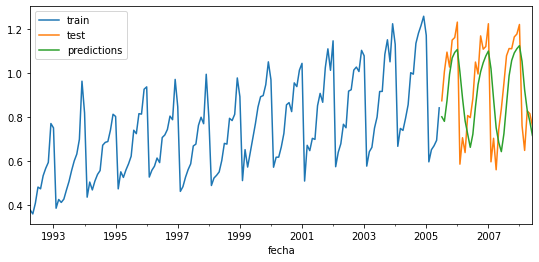

In [176]:
# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=data_test[['exog_1', 'exog_2']])

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test.y,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

In [178]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor=RandomForestRegressor(random_state=123),
                lags=12
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train['y'],
                        exog        = data_train[['exog_1', 'exog_2']],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        refit       = False,
                        initial_train_size    = int(len(data_train)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

Number of models compared: 12


loop lags_grid: 100%|█████████████████████████████| 3/3 [00:05<00:00,  1.94s/it]

Refitting `forecaster` using the best found parameters and the whole data set: 
  lags: 3 
  params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric,max_depth,n_estimators
2,3,"{'max_depth': 10, 'n_estimators': 50}",0.018956,10,50
6,10,"{'max_depth': 10, 'n_estimators': 50}",0.018956,10,50
10,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.018956,10,50
0,3,"{'max_depth': 5, 'n_estimators': 50}",0.019244,5,50
4,10,"{'max_depth': 5, 'n_estimators': 50}",0.019244,5,50
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.019244,5,50
3,3,"{'max_depth': 10, 'n_estimators': 100}",0.020106,10,100
7,10,"{'max_depth': 10, 'n_estimators': 100}",0.020106,10,100
11,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 100}",0.020106,10,100
1,3,"{'max_depth': 5, 'n_estimators': 100}",0.020165,5,100


# Información de sesión

In [39]:
import session_info
session_info.show(html=False, write_req_file=False)

-----
matplotlib          3.4.3
numpy               1.19.5
pandas              1.2.5
session_info        1.0.0
skforecast          0.4.dev
sklearn             1.0.1
-----
IPython             7.26.0
jupyter_client      6.1.7
jupyter_core        4.6.3
jupyterlab          2.1.3
notebook            6.4.0
-----
Python 3.7.9 (default, Aug 31 2020, 12:42:55) [GCC 7.3.0]
Linux-5.11.0-38-generic-x86_64-with-debian-bullseye-sid
-----
Session information updated at 2021-10-31 21:47
